In [1]:
# Install Prophet (Meta's time series model)
!pip install prophet

# Install XGBoost
!pip install xgboost


In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series and forecasting models
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Warnings off
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load the dataset
df = pd.read_csv("/content/household_power_consumption.csv")
df.head()



,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


In [4]:
# Combine 'Date' and 'Time' into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Set Datetime as the index
df.set_index('Datetime', inplace=True)

# Drop old Date, Time columns if no longer needed
df.drop(columns=['Date', 'Time'], inplace=True)

# Sort by datetime index (just in case)
df.sort_index(inplace=True)

# View the updated structure
df.head()


,index,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,
2007-01-01 00:00:00,0,2.58,0.136,241.97,10.6,0,0,0.0
2007-01-01 00:01:00,1,2.552,0.1,241.75,10.4,0,0,0.0
2007-01-01 00:02:00,2,2.55,0.1,241.64,10.4,0,0,0.0
2007-01-01 00:03:00,3,2.55,0.1,241.71,10.4,0,0,0.0
2007-01-01 00:04:00,4,2.554,0.1,241.98,10.4,0,0,0.0


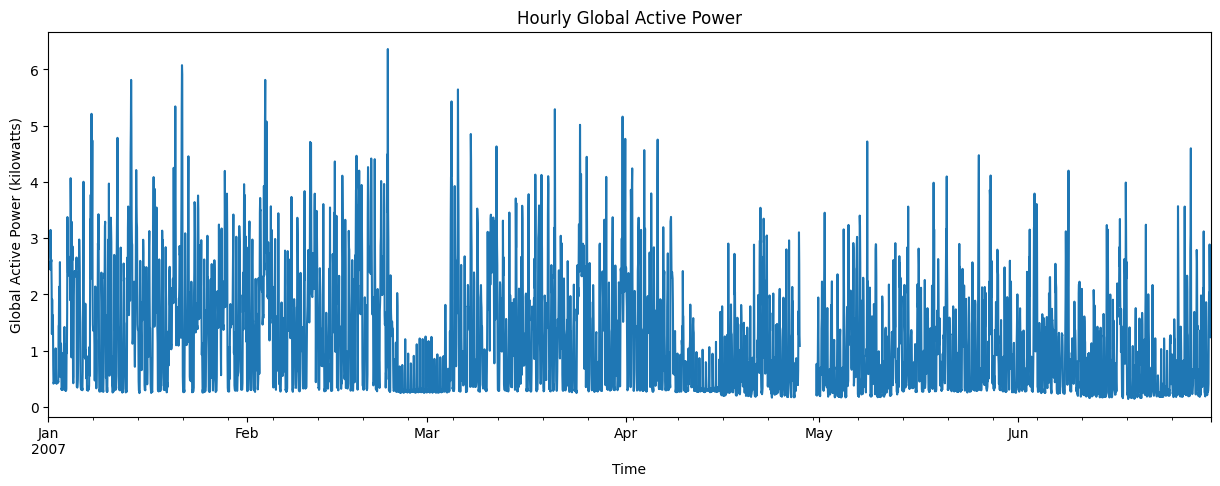

In [5]:
# Convert to numeric (in case there are string values or '?')
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop rows with missing values
df.dropna(subset=['Global_active_power'], inplace=True)

# Resample to hourly average energy consumption
df_hourly = df['Global_active_power'].resample('H').mean()

# Visualize hourly consumption
import matplotlib.pyplot as plt

df_hourly.plot(figsize=(15, 5), title='Hourly Global Active Power')
plt.ylabel('Global Active Power (kilowatts)')
plt.xlabel('Time')
plt.show()


In [6]:
# Reset index to use datetime for feature extraction
df_feat = df_hourly.reset_index()

# Create time-based features
df_feat['hour'] = df_feat['Datetime'].dt.hour
df_feat['dayofweek'] = df_feat['Datetime'].dt.dayofweek
df_feat['is_weekend'] = df_feat['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Rename target column
df_feat['target'] = df_feat['Global_active_power']

# Drop any remaining NaNs
df_feat.dropna(inplace=True)

# Preview
df_feat.head()


,Datetime,Global_active_power,hour,dayofweek,is_weekend,target
0,2007-01-01 00:00:00,2.550633,0,0,0,2.550633
1,2007-01-01 01:00:00,2.523400,1,0,0,2.523400
2,2007-01-01 02:00:00,2.582333,2,0,0,2.582333
3,2007-01-01 03:00:00,2.541667,3,0,0,2.541667
4,2007-01-01 04:00:00,2.475733,4,0,0,2.475733


In [7]:
# Define split index
train_size = int(len(df_feat) * 0.8)

# Split into training and testing sets
train = df_feat[:train_size]
test = df_feat[train_size:]

# Confirm sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 3426, Test size: 857


In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data (target only)
arima_model = ARIMA(train['target'], order=(5,1,0))  # You can tune (p,d,q)
arima_result = arima_model.fit()

# Forecast for test period
arima_forecast = arima_result.forecast(steps=len(test))


In [9]:
from prophet import Prophet

# Prepare data
df_prophet = df_feat[['Datetime', 'target']].rename(columns={'Datetime': 'ds', 'target': 'y'})
train_p = df_prophet[:train_size]
test_p = df_prophet[train_size:]

# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_p)

# Future DataFrame (next N hours)
future = prophet_model.make_future_dataframe(periods=len(test), freq='H')

# Forecast
forecast = prophet_model.predict(future)

# Get only forecasted values for test period
prophet_forecast = forecast['yhat'].iloc[-len(test):].values


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu2e5cbi6/sb35deag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu2e5cbi6/_164elmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55159', 'data', 'file=/tmp/tmpu2e5cbi6/sb35deag.json', 'init=/tmp/tmpu2e5cbi6/_164elmm.json', 'output', 'file=/tmp/tmpu2e5cbi6/prophet_model_6893te5/prophet_model-20250728154454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
from xgboost import XGBRegressor

# Features and target
features = ['hour', 'dayofweek', 'is_weekend']

x_train = train[features]
y_train = train['target']

x_test = test[features]
y_test = test['target']

# Train model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(x_train, y_train)

# Predict
xgb_forecast = xgb_model.predict(x_test)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ARIMA
mae_arima = mean_absolute_error(test['target'], arima_forecast)
rmse_arima = mean_squared_error(test['target'], arima_forecast) ** 0.5

# Prophet
mae_prophet = mean_absolute_error(test['target'], prophet_forecast)
rmse_prophet = mean_squared_error(test['target'], prophet_forecast) ** 0.5

# XGBoost
mae_xgb = mean_absolute_error(test['target'], xgb_forecast)
rmse_xgb = mean_squared_error(test['target'], xgb_forecast) ** 0.5

# Print the results
print("ARIMA -> MAE:", mae_arima, ", RMSE:", rmse_arima)
print("Prophet -> MAE:", mae_prophet, ", RMSE:", rmse_prophet)
print("XGBoost -> MAE:", mae_xgb, ", RMSE:", rmse_xgb)


ARIMA -> MAE: 0.6024936624199809 , RMSE: 0.946180007590233
Prophet -> MAE: 0.5868453422026709 , RMSE: 0.7585823906980604
XGBoost -> MAE: 0.6372732907432688 , RMSE: 0.8074460671388249


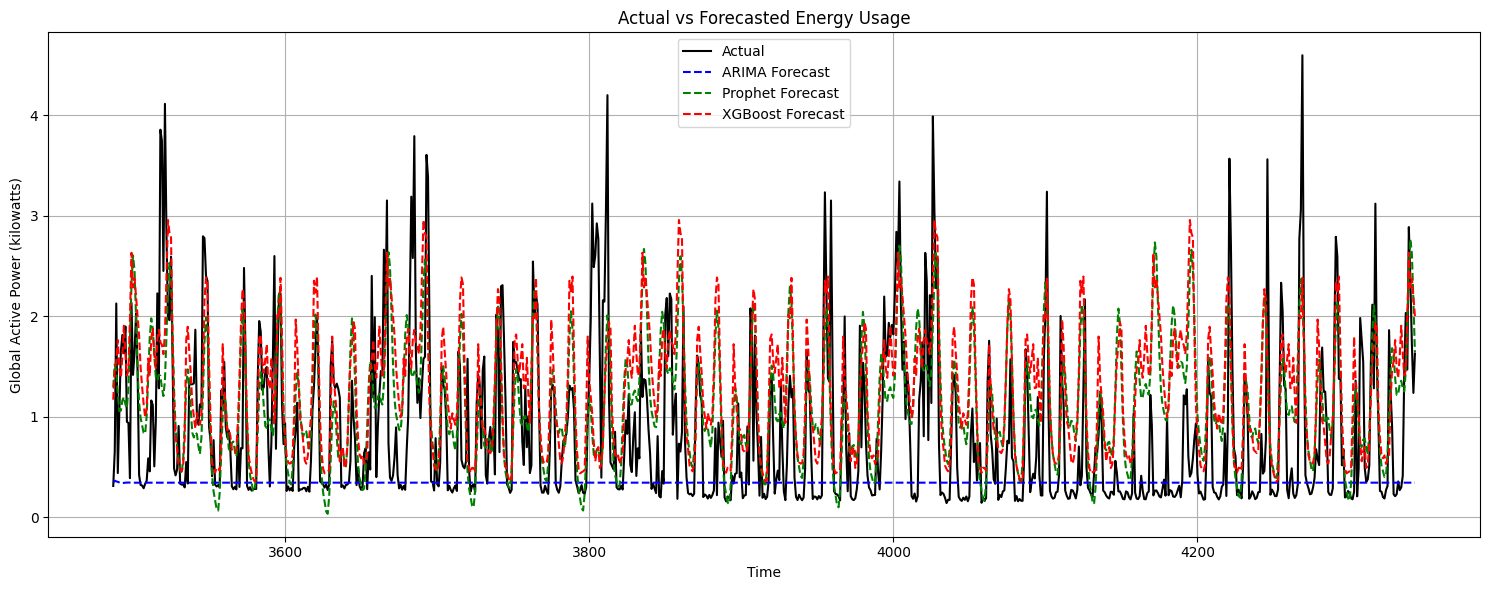

In [20]:
import matplotlib.pyplot as plt

# Set figure size for better readability
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(test.index, test['target'], label='Actual', color='black')

# Plot ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# Plot Prophet forecast
plt.plot(test.index, prophet_forecast, label='Prophet Forecast', color='green', linestyle='--')

# Plot XGBoost forecast
plt.plot(test.index, xgb_forecast, label='XGBoost Forecast', color='red', linestyle='--')

# Title and labels
plt.title('Actual vs Forecasted Energy Usage')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
